# Q2 K-Means Clustering

## 2.1 Implement a K-Means Class

### Import necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score

### K-Means Class

In [2]:
class KMeans:
    """
    n_clusters : int
        The number of clusters to form.
    max_iters : int
        Maximum number of iterations of the K-Means algorithm.
    centroids : np.ndarray
        The coordinates of the cluster centers.
    """

    def __init__(self, n_clusters: int = 3, max_iters: int = 100):
        """
        Initialize the KMeans object with the number of clusters and iterations.

        n_clusters : int, optio
            The number of clusters to form (default is 3).
        max_iters : int, optional
            Maximum number of iterations of the K-Means algorithm (default is 100).
        """
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.centroids = None

    def fit(self, X: np.ndarray):
        """
        Compute K-Means clustering on the dataset.

        X : np.ndarray
            The input data of shape (n_samples, n_features).
        """

        # Ensure NumPy array
        if isinstance(X, pd.DataFrame):
            X = X.values

        # Randomly initialize centroids
        np.random.seed(69)
        random_indices = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[random_indices]

        for _ in range(self.max_iters):
            # Assign clusters
            labels = self.predict(X)

            # Compute new centroids
            new_centroids = []
            for i in range(self.n_clusters):
                cluster_points = X[labels == i]
                if len(cluster_points) > 0:
                    centroid = cluster_points.mean(axis=0)
                else:
                    # If a cluster lost all its points, keep the previous centroid
                    centroid = self.centroids[i]
                new_centroids.append(centroid)
                
            new_centroids = np.array(new_centroids)

            # Check for convergence
            if np.allclose(self.centroids, new_centroids, atol=1e-6):
                break

            self.centroids = new_centroids

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict the closest cluster each sample in X belongs to.

        X : np.ndarray
            New data to predict of shape (n_samples, n_features).

        Returns
        labels : np.ndarray
            Index of the cluster each sample belongs to.

        """
        if isinstance(X, pd.DataFrame):
            X = X.values
            
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        # print(distances)
        return np.argmin(distances, axis=1)

    def getCost(self, X: np.ndarray) -> float:
        """
        Compute the Within-Cluster Sum of Squares (WCSS).

        X : np.ndarray
            The input data of shape (n_samples, n_features).

        Returns
        cost : float
            The WCSS value.
        """
        if isinstance(X, pd.DataFrame):
            X = X.values
            
        labels = self.predict(X)
        cost = 0.0
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]
            cost += np.sum((cluster_points - self.centroids[i]) ** 2)
        return cost


### Load and Preprocess the Dataset

In [3]:
df = pd.read_csv("Dataset/Clustering_dataset.csv")
print("Dataset shape:", df.shape)
df.describe()

# Drop CustomerID (not useful for clustering)
df = df.drop(columns=["CustomerID"])

# Drop rows if any of the collumns have missing values
df = df.dropna()
print("Dataset shape after dropping missing values:", df.shape, "\n")

# Encode categorical "Genre"
label_encoder = LabelEncoder()
df["Genre"] = label_encoder.fit_transform(df["Genre"])  # Male=1, Female=0

Dataset shape: (200, 5)
Dataset shape after dropping missing values: (178, 4) 



### Data Visualization

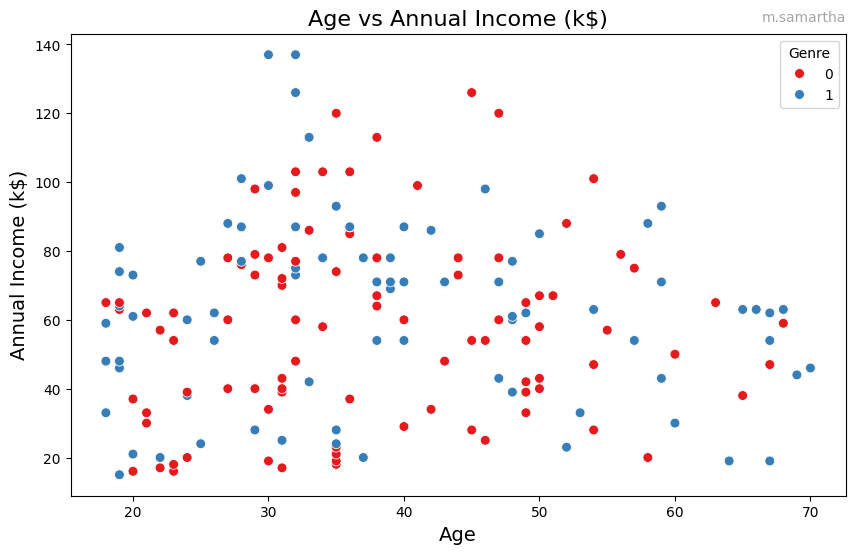

In [4]:
# Age VS Anual Income

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="Age", y= "Annual Income (k$)", hue="Genre", palette="Set1", s=50)
plt.title("Age vs Annual Income (k$)", fontsize = 16)
plt.xlabel("Age", fontsize = 14)
plt.ylabel("Annual Income (k$)", fontsize = 14)
plt.text(
    1, 1.05, "m.samartha",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    fontsize=10, color='gray', alpha=0.7
)
plt.show()

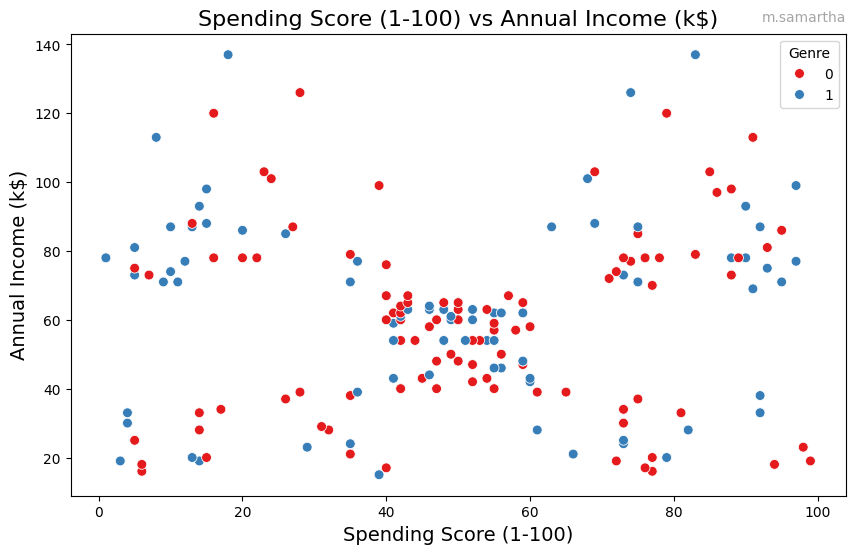

In [5]:
# Spending Score VS Anual Income

plt.figure(figsize=(10,6))

sns.scatterplot(data=df, x="Spending Score (1-100)", y= "Annual Income (k$)", hue="Genre", palette="Set1", s=50)
plt.title("Spending Score (1-100) vs Annual Income (k$)", fontsize = 16)
plt.xlabel("Spending Score (1-100)", fontsize = 14)
plt.ylabel("Annual Income (k$)", fontsize = 14)
plt.text(
    1, 1.05, "m.samartha",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    fontsize=10, color='gray', alpha=0.7
)
plt.show()

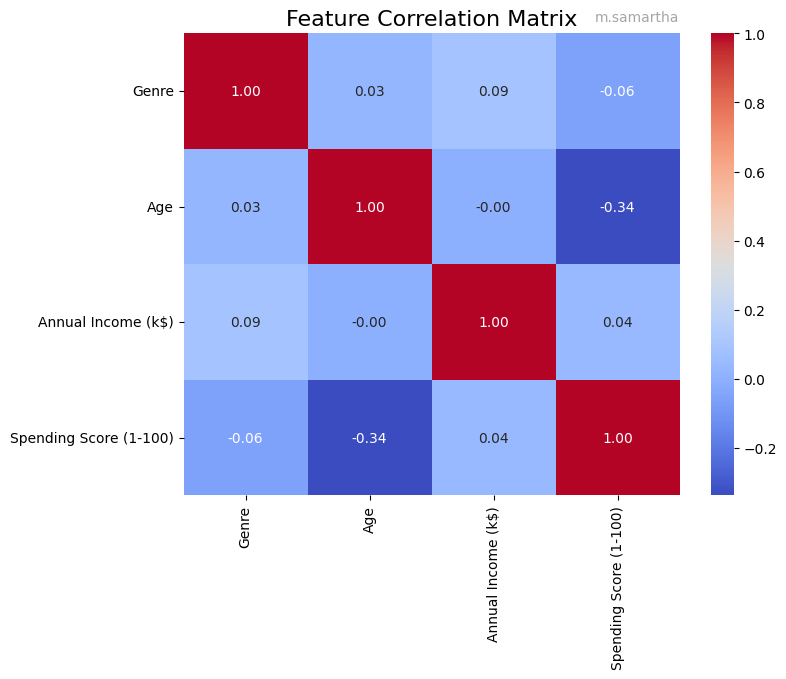

In [6]:
# Correlation matrix
correlation_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix", fontsize=16)
plt.text(
    1, 1.05, "m.samartha",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    fontsize=10, color='gray', alpha=0.7
)
plt.show()

### Observations regarding Feature Selection
From the **Annual Income vs Age** plot, we can see that there is no clear distinction between the clusters. The data points are scattered without any obvious grouping based on age and annual income. However, in the **Annual Income vs Spending Score** plot, we can observe distinct clusters. There are clear groupings of data points that indicate different spending behaviors among customers with varying annual incomes.

Moreover from the correlation matrix we see that **Age** has a large magnitude of correlation with **Spending Score** indicating that age is a redundant feature when we have spending score in our dataset. **Gender** is a categorical feature and does not contribute to the clustering process in K-Means, which relies on numerical distance calculations.

Hence, we will use **Annual Income** and **Spending Score** as the features for clustering.

### Apply K-Means Clustering

WCSS (Cost): 58.061908266931425


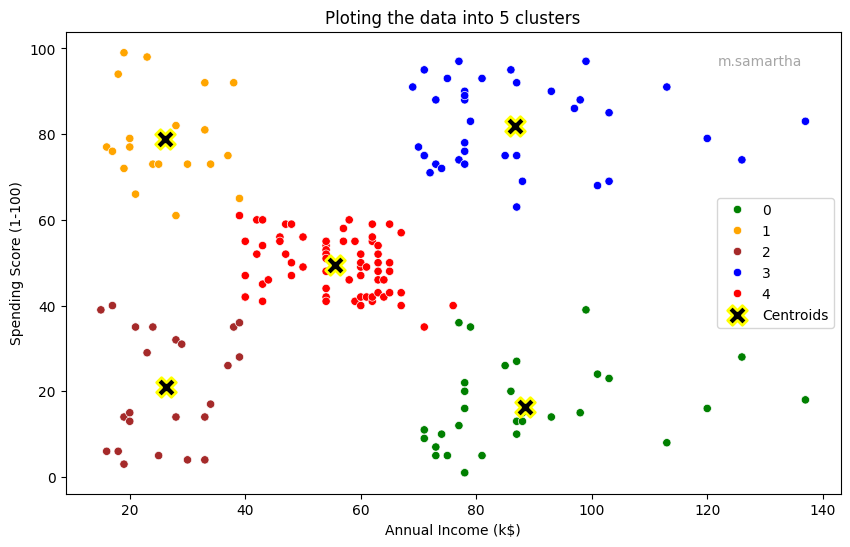

In [7]:
# Select features for clustering
X = df[["Annual Income (k$)", "Spending Score (1-100)"]].values   # numpy array

# Standardize features for fair comparison
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, max_iters=100)  # choose K=5 as example
kmeans.fit(X_scaled)

labels = kmeans.predict(X_scaled)
cost = kmeans.getCost(X_scaled)

print("WCSS (Cost):", cost)
df["Cluster"] = labels

plt.figure(figsize=(10,6))
plt.title("Ploting the data into 5 clusters")
sns.scatterplot(
    data=df, 
    x="Annual Income (k$)", 
    y="Spending Score (1-100)", 
    hue=labels,  
    palette=['green','orange','brown','blue','red'],
    legend='full'
)

# Plot centroids
centroids = scaler.inverse_transform(kmeans.centroids)
plt.scatter(
    centroids[:, 0], 
    centroids[:, 1], 
    marker='X', 
    s=200, 
    c='black', 
    edgecolor='yellow',
    linewidths=2,
    label='Centroids'
)

plt.text(
    0.95, 0.95, "m.samartha",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    fontsize=10, color='gray', alpha=0.7
)
plt.legend()
plt.show()

### Observations on Clustering Results
The clustering results show distinct groups of customers based on their annual income and spending score. Each cluster represents a different segment of customers with similar spending behaviors and income levels.

- **Cluster 0**: High income, low spending score
- **Cluster 1**: Low income, high spending score
- **Cluster 2**: Low income, low spending score
- **Cluster 3**: High income, high spending score
- **Cluster 4**: Medium income, medium spending score

These insights can help businesses tailor their marketing strategies and product offerings to better meet the needs of each customer segment.

## 2.2 Determine the Optimal Number of Clusters

### Elbow Method

Fitting for K = 1: Fitting for K = 2: Fitting for K = 3: Fitting for K = 4: Fitting for K = 5: Fitting for K = 6: Fitting for K = 7: Fitting for K = 8: Fitting for K = 9: Fitting for K = 10: 

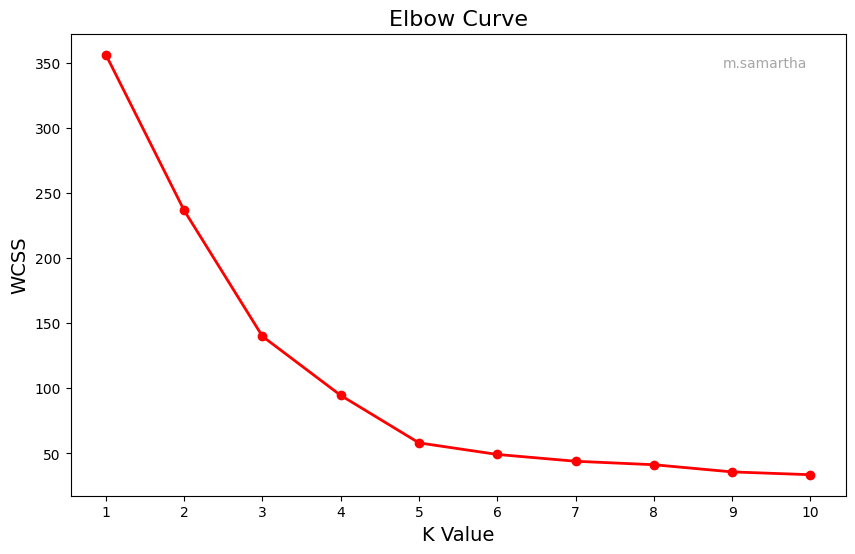

In [8]:
# Plot Elbow Curve (WCSS vs K)

wcss = []
for num_clusters in range(1,11):
    print("Fitting for K =", num_clusters, end=": ")
    kmeans = KMeans(n_clusters=num_clusters, max_iters=100)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.getCost(X_scaled))

plt.figure(figsize=(10,6))
plt.plot(range(1,11), wcss, linewidth=2, color="red", marker ="o")
plt.title("Elbow Curve", fontsize=16)
plt.xlabel("K Value", fontsize=14)
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS", fontsize=14)

plt.text(
    0.95, 0.95, "m.samartha",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    fontsize=10, color='gray', alpha=0.7
)
plt.show()

#### Observations from Elbow Method
The Elbow Method plot shows a clear "elbow" point at K=5, indicating that 5 clusters is an optimal choice for this dataset. Beyond this point, the decrease in WCCS becomes less significant, suggesting that adding more clusters does not provide substantial improvement in clustering quality. Therefore, we can conclude that using 5 clusters is appropriate for segmenting the customers in this dataset.

### Silhouette Method

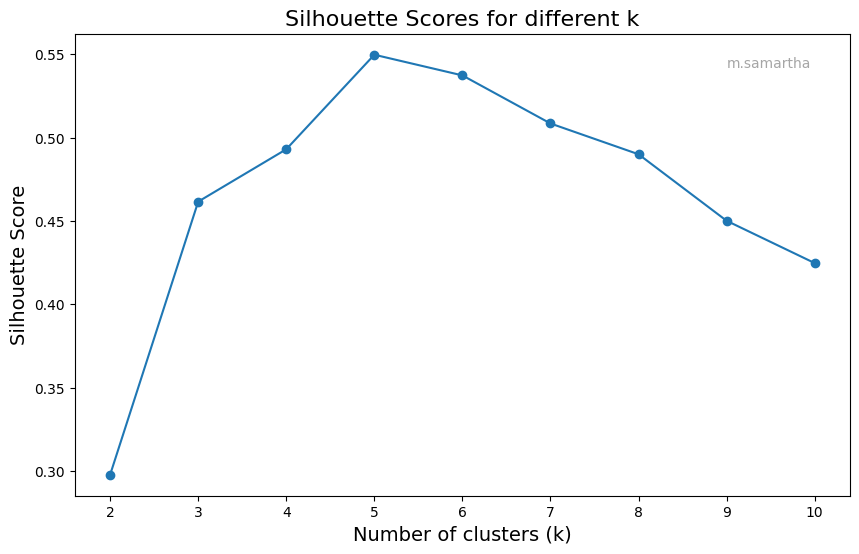

In [9]:
sil_scores = []
K = range(2, 11) 

for k in K:
    kmeans = KMeans(n_clusters=k, max_iters=100)
    kmeans.fit(X_scaled)
    labels = kmeans.predict(X_scaled)

    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

plt.figure(figsize=(10,6))
plt.plot(K, sil_scores, marker='o')
plt.title("Silhouette Scores for different k", fontsize=16)
plt.xlabel("Number of clusters (k)", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.text(
    0.95, 0.95, "m.samartha",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    fontsize=10, color='gray', alpha=0.7
)
plt.show()

#### Observations from Silhouette Method
The Silhouette Method plot shows that the silhouette score peaks at K=5, indicating that 5 clusters is the optimal number for this dataset. A higher silhouette score suggests that the clusters are well-defined and distinct from each other. Therefore, we can conclude that using 5 clusters is appropriate for segmenting the customers in this dataset. The clusters obtained will have good intra-cluster **cohesion** and inter-cluster **separation**.